### Fit logistic regression to responses against predictors for selected sample grids

#### Data used

- Predictands: gridded precipitation data (AGCD v1), gridded evapotranspiration and runoff data (AWRA)
- Predictors: season, climate drivers (ENSO, IOD, and SAM, these could be categorical or quantitative)

#### Code fits the model to data at various time scales and thresholds, and creates summary plots to visualise results

In [1]:
%who

Interactive namespace is empty.


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [31]:
# Fitting logistic regression models to test grid points

import xarray as xr
import numpy as np
import pandas as pd
from statsmodels.formula.api import glm
import statsmodels.api as sm
# model = glm(formula, data, family)

out_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

varname = 'PminusE' #'P'   # the name of the directory and file
vname = 'PminusE' #'precip'  # the name of the variable inside the files
fname = varname + '_*_SEA_*.nc'

# select some thresholds to look at
threshList = [50, 100, 150]

# select some lat-lons to look at
latList = [-34, -34, -34, -37, -37, -37]
lonList = [148, 145, 142, 148, 145, 142]

# select some timescales for analysis
ts = [2, 6, 8, 12]

# get the sst predictors
sst_dir = '/g/data/w97/ad9701/p_prob_analysis/sst_data/'
pNames = ['soi', 'sami', 'dmi', 'nino34_anom', 'nino4_anom']
pFiles = ['soi_monthly.nc', 'newsam.1957.2021.nc', 'dmi.had.long.data.nc', 'nino34.long.anom.data.nc', 'nino4.long.anom.data.nc']
for p in np.arange(len(pNames)):
    ds_temp = xr.open_dataset(sst_dir+pFiles[p])
    if (p>0):
        ds_p[pNames[p]]=ds_temp[pNames[p]]
    else:
        ds_p = ds_temp
    del ds_temp

# select the predictors to include in the model
predSel = ['season', 'soi', 'dmi']
formula = 'response ~ C(season)+soi+dmi'
    
# function to create a new data frame that will be used to 'predict' probabilities from the fitted model
# the new data points would cover combinations of unique values for categorical predictors and mean/perturbations one sd above the mean for quantitative predictors
import itertools
import pandas as pd
def createNewDf(df, fields):
    '''Function creates a sample dataframe from a larger input dataframe (df).
       The sample points will include all permutations of columns specfied (fields).
       String columns: use unique values. Numeric columns: Mean, Mean-1SD, Mean+1SD
    '''
    dataVal = []
    for f in fields:
        # str data types are assumed to be categorical variables
        if (isinstance(df[f][0], str)):
            dataVal.append(pd.unique(df[f]))
        else:
            temp = [df[f].mean()]
            temp.extend([df[f].mean()+df[f].std(), df[f].mean()-df[f].std()])
            dataVal.append(temp)
            del temp
    # get all combinations of values across the fields
    dataValPermute = list(itertools.product(*dataVal))
    # make it into a data frame
    newDf = pd.DataFrame(dataValPermute, columns = fields)
    return(newDf)

def addLatLonTh(df, latSel, lonSel, threshSel):
    df.update({'lat':latSel})
    df.update({'lon':lonSel})
    df.update({'threshold':threshSel})
    return(df)

lgR_params_list = []
lgR_pvalues_list = []
lgR_pred_list = []

for iW in ts:
    data_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'+varname+'_week'+str(iW)+'/'
    ds = xr.open_mfdataset(data_dir + fname, chunks = {'lat':400, 'lon':400})
    
    # select predictors for the same period as the data
    x1 = ds['time.season'].values     # season, this is the first predictor
    da_time_bymon = np.array(pd.to_datetime(ds.time).to_period('M').to_timestamp().floor('D'))
    ds_p_sel = ds_p.sel(time = da_time_bymon)
    xp = []
    for p in pNames:
        xp.append(ds_p_sel[p].values)
    xp_dict = dict(zip(pNames, xp))
    xp_dict.update({"season": x1})    # add season to the sst predictors    
    xp_df = pd.DataFrame(xp_dict)     # make a dataframe of predictors
    
    # create a new df of sample points at which 'predictions' will be made using the fitted model
    newDf = createNewDf(xp_df, predSel)
    
    lgR_params = {}
    lgR_pvalues = {}
    lgR_pred = {}
    
    for iPt in np.arange(len(latList)):
        latSel = latList[iPt]
        lonSel = lonList[iPt]
        da_pt = ds[vname].sel(lat = latSel, lon = lonSel).load()

        for ith in np.arange(len(threshList)):
            # field name to save the results
            field = 'p'+str(iPt)+'_th'+str(ith)
            
            # create a dataframe of reponse and predictors
            y = np.where(da_pt.values>=threshList[ith], 1, 0)
            d = {"response": y}
            if (sum(y)<4):
                p_pred = newDf.copy()
                p_pred['prob'] = 0
                lgR_params.update({field:np.nan})
                lgR_pvalues.update({field:np.nan})     
            else:
                d.update(xp_dict)
                df = pd.DataFrame(d)

                # fit the regression model
                model = glm(formula, df, family=sm.families.Binomial())
                model_GLM = model.fit()
                p_pred = newDf.copy()
                prob = model_GLM.predict(newDf)
                p_pred['prob'] = prob
            
                # save the results
                lgR_params.update({field:model_GLM.params})
                lgR_pvalues.update({field:model_GLM.pvalues})
            
            lgR_pred.update({field:p_pred})
    
    addLatLonTh(lgR_params, latSel, lonSel, threshList[ith])
    addLatLonTh(lgR_pvalues, latSel, lonSel, threshList[ith])
    addLatLonTh(lgR_pred, latSel, lonSel, threshList[ith])

    lgR_params_list.append(lgR_params)
    lgR_pvalues_list.append(lgR_pvalues)
    lgR_pred_list.append(lgR_pred)
    

In [18]:
lgR_pred_list[1]['p0_th0'].head()

,season,soi,dmi,prob
0,SON,0.017981,-0.088646,0.063250
1,SON,0.017981,0.246583,0.060235
2,SON,0.017981,-0.423874,0.066406
3,SON,10.007057,-0.088646,0.087358
4,SON,10.007057,0.246583,0.083295


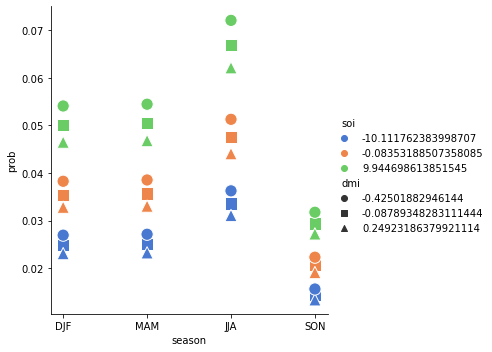

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# SMALLEST = 6
# SMALL_SIZE = 14
# MEDIUM_SIZE = 18
# BIGGER_SIZE = 18

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALLEST)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALLEST)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

test_df = lgR_pred_list[0]['p0_th0']

sns.relplot(data=test_df, x="season", y="prob", hue="soi", style="dmi", s=150, palette="muted", markers=['o','s', '^'])